<a href="https://colab.research.google.com/github/GuendouziWassila/CovNet_Binary_Image_Classification_Cat_Dog/blob/main/ImageBinaryClassification_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import shutil

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')


# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  infl

In [ ]:
# 3
train_image_generator =ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'         )

val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'         )

# Create a temporary directory and copy test images into it : we are doing this because all the images in your test dataset are directly in the test_dir without being organized into subdirectories based on classes
temp_test_dir = os.path.join(PATH, 'temp_test')
shutil.rmtree(temp_test_dir, ignore_errors=True)  # Delete the existing directory
os.makedirs(temp_test_dir, exist_ok=True)
shutil.copytree(test_dir, os.path.join(temp_test_dir, 'test'))

test_data_gen = test_image_generator.flow_from_directory(
        temp_test_dir,
        shuffle=False,# shuffle=False means that the order of the images in the dataset will not be shuffled during the generation of batches.
        target_size=(150,150),
        batch_size=batch_size,
        class_mode=None,# No class labels for the test dataset
        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


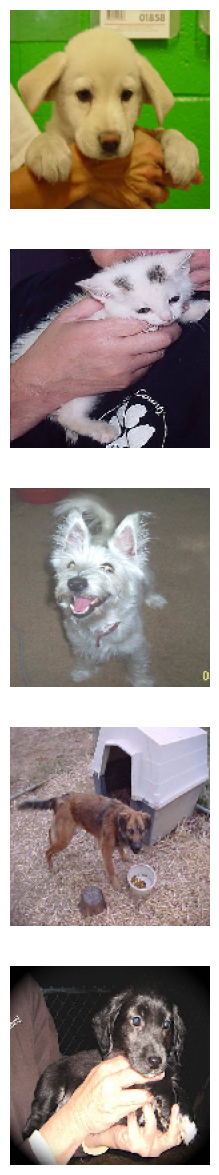

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# 5
#avoid overfitting caused by small training data by creating more training data from existing training examples by using random transformations.
train_image_generator = ImageDataGenerator(

    rescale=1./255,
    rotation_range=40,        # Degree range for random rotations
    width_shift_range=0.2,    # Range for random horizontal shifts
    height_shift_range=0.2,   # Range for random vertical shifts
    shear_range=0.2,          # Shear intensity
    zoom_range=0.2,           # Range for random zoom
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Strategy for filling in newly created pixels
)



Found 2000 images belonging to 2 classes.


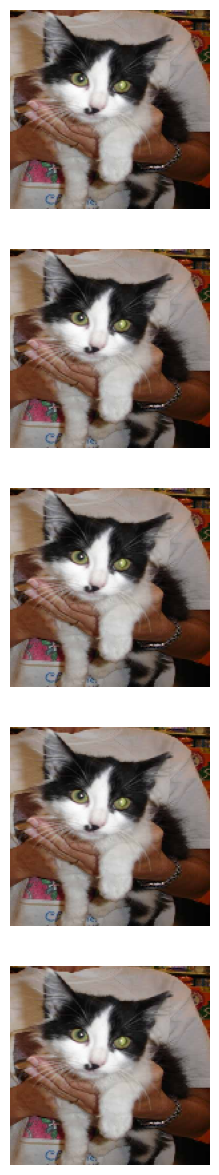

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# 7
#create the model
model = Sequential()

# Add Convolutional and Pooling Layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification, change to the number of classes for multi-class



# Compile the model
model.compile(optimizer='adam',  # You can replace 'adam' with other optimizers like 'sgd' or 'rmsprop'
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 17, 17, 128)      

In [ ]:
# 8
# Use the fit method to train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),# Number of steps per epoch (total training samples / batch size)
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen)# Number of steps per epoch (total training samples / batch size)
)

Epoch 1/15
16/16 [==============================] - 7s 348ms/step - loss: 0.9488 - accuracy: 0.5000 - val_loss: 0.6891 - val_accuracy: 0.6240
Epoch 2/15
16/16 [==============================] - 6s 375ms/step - loss: 0.6847 - accuracy: 0.5685 - val_loss: 0.6748 - val_accuracy: 0.6150
Epoch 3/15
16/16 [==============================] - 5s 331ms/step - loss: 0.6565 - accuracy: 0.6055 - val_loss: 0.6343 - val_accuracy: 0.6450
Epoch 4/15
16/16 [==============================] - 8s 496ms/step - loss: 0.6106 - accuracy: 0.6735 - val_loss: 0.6356 - val_accuracy: 0.6060
Epoch 5/15
16/16 [==============================] - 6s 390ms/step - loss: 0.5636 - accuracy: 0.7060 - val_loss: 0.5932 - val_accuracy: 0.6900
Epoch 6/15
16/16 [==============================] - 7s 416ms/step - loss: 0.5125 - accuracy: 0.7475 - val_loss: 0.5813 - val_accuracy: 0.6930
Epoch 7/15
16/16 [==============================] - 5s 326ms/step - loss: 0.4644 - accuracy: 0.7810 - val_loss: 0.6072 - val_accuracy: 0.6920
Epoch 

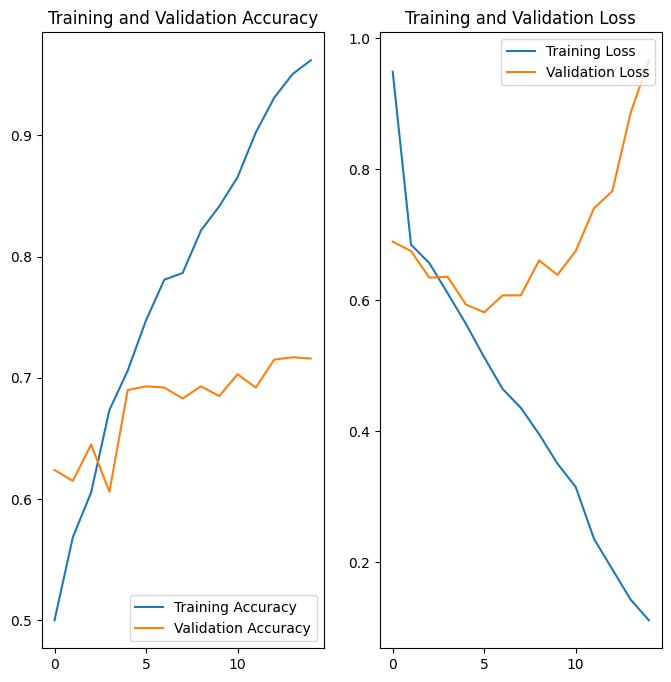

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model.save('/content/gdrive/MyDrive/cats_and_dogs_model.keras')
os.path.exists('/content/gdrive/MyDrive/cats_and_dogs_model.keras')
#model=tf.keras.models.load_model('/content/gdrive/MyDrive/cats_and_dogs_model.keras')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


True

2/2 [==============================] - 0s 10ms/step
[0.52287596]


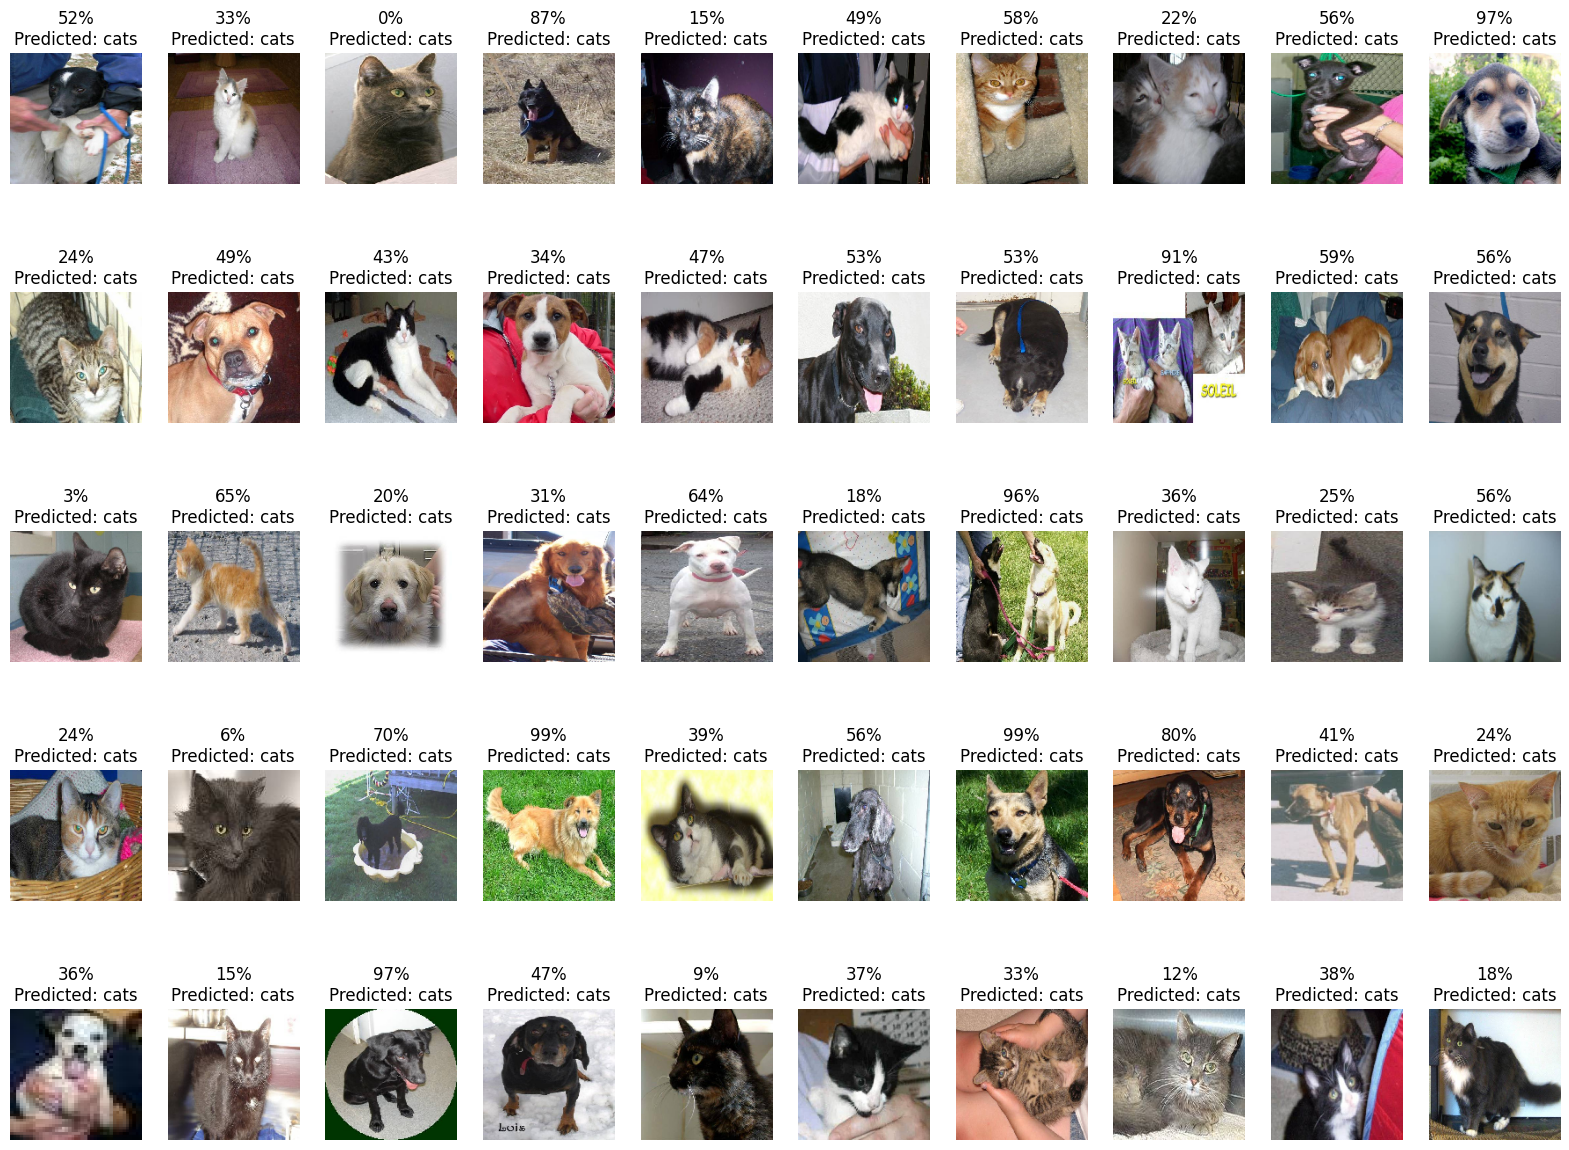

In [ ]:
# Get the class indices from the generator
class_indices = train_data_gen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())

# Get the test images (no corresponding labels)
test_images = next(test_data_gen)

# Predict probabilities for each test image
probabilities = model.predict(test_images)
print (probabilities[0])
# Convert probabilities to a list of integers (percentage confidence)
confidence_percentages = [int(prob * 100) for prob in np.squeeze(probabilities)]

# Define a function to plot images with predicted labels and confidence percentages
def plot_images(images, confidence_percentages):
    plt.figure(figsize=(20, 15))
    for i in range(len(images)):
        plt.subplot(5, 10, i + 1)
        plt.imshow(images[i])
        plt.title(f"{confidence_percentages[i]}%\nPredicted: {class_indices[np.argmax(probabilities[i])]}")
        plt.axis('off')
    plt.show()

# Plot the images with predicted labels and confidence percentages

plot_images(test_images, confidence_percentages)


In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")



Your model correctly identified 76.0% of the images of cats and dogs.
You passed the challenge!
